In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
PATH_OF_DATA= '/content/gdrive/My Drive/Abstract_gallery'
# !ls {PATH_OF_DATA}

In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import Image
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.utils import save_image

In [ ]:
stats = (.5, .5, .5), (.5, .5, .5)

In [ ]:
transform_ds = T.Compose([
    T.Resize((128, 128)),
    T.CenterCrop(128),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.ToTensor(),
    T.Normalize(*stats)
])
ds = torchvision.datasets.ImageFolder(root=PATH_OF_DATA, transform=transform_ds)

In [ ]:
def denorm(img_tensor):
    return img_tensor * stats[1][0] + stats[0][0]

In [ ]:
batch_size=128

In [ ]:
train_dl = DataLoader(ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


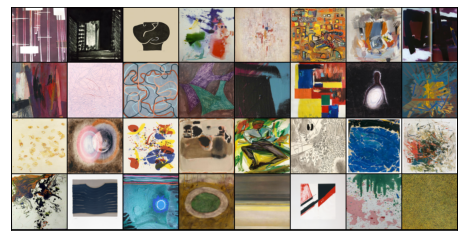

In [ ]:
def show_image(train_dl):
    for images,_ in train_dl:
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(denorm(images.detach()[:32]), nrow=8).permute(1,2,0))
        break

show_image(train_dl)

In [ ]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for x in self.dl:
            yield to_device(x, self.device)

    def __len__(self):
        return len(self.dl)

device = get_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
discriminator = nn.Sequential(
    #in: 128 x 3 x 128 x 128

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    #128 x 64 x 64 x 64

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    #128 x 128 x 32 x 32

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    #128 x 256 x 16 x 16

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    #128 x 512 x 8 x 8

    nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2, inplace=True),
    #128 x 1024 x 4 x 4

    nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0, bias=False),
    #128 x 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()

)

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size=128

In [ ]:
generator = nn.Sequential(
    #in: 128 x 1 x 1

    nn.ConvTranspose2d(latent_size, 1024, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),
    #128 x 1024 x 4 x 4

    nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    #128 x 512 x 8 x 8

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    #128 x 256 x 16 x 16

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    #128 x 128 x 32 x 32

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    #128 x 64 x 64 x 64

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    #128 x 3 x 128 x 128
    nn.Tanh()


)

In [ ]:
generator = to_device(generator, device)

In [ ]:
def train_discriminator(real_images, opt_d):
    opt_d.zero_grad()

    real_preds= discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    latent = torch.randn(latent_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    fake_preds= discriminator(fake_images)
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    loss = real_loss + fake_loss
    loss.backward(),
    opt_d.step()

    return loss.item(), real_score, fake_score

In [ ]:
def train_generator(opt_g):
    opt_g.zero_grad()

    latent = torch.randn(latent_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    preds = discriminator(fake_images)
    targets = torch.ones(fake_images.size(0), 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    loss.backward(),
    opt_g.step()

    return loss.item()

In [ ]:
sample_dir = "generated"
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_sample(index, fixed_latent, show=True):
    fake_images = generator(fixed_latent)
    fake_fname = "generated-images-{0:0=4d}.png".format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    if show:
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach()[:32], nrow=8).permute(1,2,0))

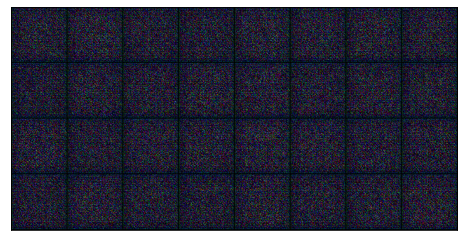

In [ ]:
fixed_latent = torch.randn(128, latent_size, 1, 1, device=device)
save_sample(0, fixed_latent, show=True)

In [ ]:
def fit(epochs, lr_d, lr_g, start_idx=1):
    torch.cuda.empty_cache()

    losses_d = []
    losses_g = []
    real_scores = []
    fake_scores = []

    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images,_ in tqdm(train_dl):
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            loss_g = train_generator(opt_g)

        losses_d.append(loss_d)
        losses_g.append(loss_g)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        print("Epoch: [{}/{}], loss_d: {:.4f}, loss_g: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
        epoch+1, epochs, loss_d, loss_g, real_score, fake_score))

        save_sample(epoch+start_idx, fixed_latent, show=False)

    return losses_d, losses_g, real_scores, fake_scores

In [ ]:
epochs = 200
lr_d = 10e-5
lr_g = 10e-4

In [ ]:
history = [fit(epochs, lr_d, lr_g, start_idx=1)]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [1/200], loss_d: 1.5000, loss_g: 3.7516, real_score: 0.5291, fake_score: 0.5164


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [2/200], loss_d: 1.3424, loss_g: 2.3700, real_score: 0.5224, fake_score: 0.4746


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [3/200], loss_d: 1.3907, loss_g: 1.7873, real_score: 0.5755, fake_score: 0.5434


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [4/200], loss_d: 0.6702, loss_g: 2.5695, real_score: 0.8039, fake_score: 0.3548


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [5/200], loss_d: 1.5994, loss_g: 1.0786, real_score: 0.3760, fake_score: 0.3623


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [6/200], loss_d: 1.2330, loss_g: 1.0553, real_score: 0.5213, fake_score: 0.4025


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [7/200], loss_d: 1.2915, loss_g: 1.2989, real_score: 0.5515, fake_score: 0.4586


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [8/200], loss_d: 1.2917, loss_g: 1.0702, real_score: 0.5362, fake_score: 0.4412


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [9/200], loss_d: 1.4956, loss_g: 1.0281, real_score: 0.5381, fake_score: 0.5564


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [10/200], loss_d: 1.5716, loss_g: 0.9072, real_score: 0.4234, fake_score: 0.4696


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [11/200], loss_d: 1.3921, loss_g: 0.9308, real_score: 0.5527, fake_score: 0.5171


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [12/200], loss_d: 1.4119, loss_g: 1.1661, real_score: 0.4945, fake_score: 0.4854


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [13/200], loss_d: 1.1723, loss_g: 1.2131, real_score: 0.6148, fake_score: 0.4774


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [14/200], loss_d: 1.1238, loss_g: 1.1345, real_score: 0.5772, fake_score: 0.4080


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [15/200], loss_d: 1.1909, loss_g: 1.4043, real_score: 0.6177, fake_score: 0.4729


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [16/200], loss_d: 1.1056, loss_g: 1.2084, real_score: 0.5428, fake_score: 0.3730


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [17/200], loss_d: 1.1702, loss_g: 1.6815, real_score: 0.5922, fake_score: 0.4522


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [18/200], loss_d: 1.2181, loss_g: 1.3107, real_score: 0.5569, fake_score: 0.4284


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [19/200], loss_d: 1.2358, loss_g: 1.4083, real_score: 0.5817, fake_score: 0.4637


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [20/200], loss_d: 1.0909, loss_g: 1.7965, real_score: 0.6552, fake_score: 0.4648


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [21/200], loss_d: 0.5732, loss_g: 2.1763, real_score: 0.7109, fake_score: 0.1866


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [22/200], loss_d: 1.0539, loss_g: 1.8522, real_score: 0.6370, fake_score: 0.4083


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [23/200], loss_d: 1.0663, loss_g: 1.6146, real_score: 0.5720, fake_score: 0.3396


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [24/200], loss_d: 1.1011, loss_g: 1.1712, real_score: 0.5642, fake_score: 0.3767


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [25/200], loss_d: 1.2073, loss_g: 1.3774, real_score: 0.5196, fake_score: 0.3352


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [26/200], loss_d: 1.2072, loss_g: 2.1777, real_score: 0.6360, fake_score: 0.5038


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [27/200], loss_d: 1.2422, loss_g: 0.9978, real_score: 0.4131, fake_score: 0.2057


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [28/200], loss_d: 0.9563, loss_g: 1.4176, real_score: 0.5580, fake_score: 0.2815


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [29/200], loss_d: 1.0016, loss_g: 2.3444, real_score: 0.6767, fake_score: 0.4364


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [30/200], loss_d: 0.9684, loss_g: 1.2313, real_score: 0.5211, fake_score: 0.2285


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [31/200], loss_d: 0.9693, loss_g: 2.0184, real_score: 0.6300, fake_score: 0.3617


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [32/200], loss_d: 1.4682, loss_g: 1.1964, real_score: 0.4255, fake_score: 0.3858


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [33/200], loss_d: 0.9040, loss_g: 2.3086, real_score: 0.7006, fake_score: 0.4032


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [34/200], loss_d: 1.2345, loss_g: 1.9182, real_score: 0.7721, fake_score: 0.5916


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [35/200], loss_d: 1.3494, loss_g: 1.2632, real_score: 0.5341, fake_score: 0.4592


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [36/200], loss_d: 1.1101, loss_g: 2.1342, real_score: 0.6918, fake_score: 0.4782


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [37/200], loss_d: 1.4130, loss_g: 1.5666, real_score: 0.6301, fake_score: 0.5813


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [38/200], loss_d: 0.9941, loss_g: 2.2998, real_score: 0.6780, fake_score: 0.4171


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [39/200], loss_d: 0.9108, loss_g: 2.0004, real_score: 0.5887, fake_score: 0.2716


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [40/200], loss_d: 0.9842, loss_g: 2.6120, real_score: 0.8014, fake_score: 0.4966


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [41/200], loss_d: 0.9563, loss_g: 2.2401, real_score: 0.6382, fake_score: 0.3590


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [42/200], loss_d: 1.1453, loss_g: 2.3458, real_score: 0.6847, fake_score: 0.5065


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [43/200], loss_d: 1.3968, loss_g: 1.2441, real_score: 0.3241, fake_score: 0.1413


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [44/200], loss_d: 0.9336, loss_g: 1.6919, real_score: 0.5428, fake_score: 0.1896


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [45/200], loss_d: 1.5242, loss_g: 4.1027, real_score: 0.8267, fake_score: 0.7023


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [46/200], loss_d: 1.2150, loss_g: 3.9350, real_score: 0.8788, fake_score: 0.6338


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [47/200], loss_d: 0.8723, loss_g: 1.9092, real_score: 0.6261, fake_score: 0.3011


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [48/200], loss_d: 0.6817, loss_g: 1.8229, real_score: 0.7366, fake_score: 0.2872


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [49/200], loss_d: 0.8236, loss_g: 1.4727, real_score: 0.6270, fake_score: 0.2365


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [50/200], loss_d: 0.8001, loss_g: 1.9063, real_score: 0.7704, fake_score: 0.3964


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [51/200], loss_d: 0.6488, loss_g: 2.0438, real_score: 0.7878, fake_score: 0.3070


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [52/200], loss_d: 1.2291, loss_g: 1.6983, real_score: 0.5544, fake_score: 0.4190


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [53/200], loss_d: 1.3071, loss_g: 3.5402, real_score: 0.7727, fake_score: 0.6077


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [54/200], loss_d: 1.2250, loss_g: 5.7029, real_score: 0.8564, fake_score: 0.6193


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [55/200], loss_d: 0.7283, loss_g: 2.1180, real_score: 0.5949, fake_score: 0.1184


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [56/200], loss_d: 0.7049, loss_g: 2.0314, real_score: 0.7316, fake_score: 0.3003


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [57/200], loss_d: 0.8343, loss_g: 2.8429, real_score: 0.7773, fake_score: 0.4199


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [58/200], loss_d: 1.2334, loss_g: 1.9516, real_score: 0.4989, fake_score: 0.3448


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [59/200], loss_d: 0.9321, loss_g: 2.2090, real_score: 0.5593, fake_score: 0.2354


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [60/200], loss_d: 0.5800, loss_g: 2.8756, real_score: 0.7899, fake_score: 0.2721


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [61/200], loss_d: 0.6392, loss_g: 2.7307, real_score: 0.6021, fake_score: 0.0830


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [62/200], loss_d: 1.3473, loss_g: 3.2291, real_score: 0.6689, fake_score: 0.5460


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [63/200], loss_d: 0.9729, loss_g: 3.6174, real_score: 0.7114, fake_score: 0.4322


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [64/200], loss_d: 1.0162, loss_g: 1.9007, real_score: 0.7740, fake_score: 0.4991


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [65/200], loss_d: 1.1164, loss_g: 4.0490, real_score: 0.6630, fake_score: 0.4632


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [66/200], loss_d: 0.7283, loss_g: 3.5225, real_score: 0.8052, fake_score: 0.3751


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [67/200], loss_d: 0.9163, loss_g: 3.4800, real_score: 0.6885, fake_score: 0.3577


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [68/200], loss_d: 0.8078, loss_g: 3.4890, real_score: 0.6753, fake_score: 0.2935


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [69/200], loss_d: 0.9579, loss_g: 1.6607, real_score: 0.4953, fake_score: 0.1534


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [70/200], loss_d: 0.6593, loss_g: 2.4715, real_score: 0.6770, fake_score: 0.1942


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [71/200], loss_d: 0.7476, loss_g: 2.7760, real_score: 0.7817, fake_score: 0.3664


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [72/200], loss_d: 0.6959, loss_g: 2.3913, real_score: 0.6990, fake_score: 0.2488


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [73/200], loss_d: 0.8400, loss_g: 2.6586, real_score: 0.6487, fake_score: 0.3025


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [74/200], loss_d: 1.1660, loss_g: 2.4915, real_score: 0.5691, fake_score: 0.3704


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [75/200], loss_d: 0.8215, loss_g: 2.3874, real_score: 0.7460, fake_score: 0.3738


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [76/200], loss_d: 0.8614, loss_g: 1.6759, real_score: 0.5427, fake_score: 0.1324


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [77/200], loss_d: 0.7751, loss_g: 2.8451, real_score: 0.6048, fake_score: 0.2064


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [78/200], loss_d: 0.9607, loss_g: 1.9208, real_score: 0.4515, fake_score: 0.1037


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [79/200], loss_d: 0.9302, loss_g: 2.0193, real_score: 0.5481, fake_score: 0.2134


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [80/200], loss_d: 0.8217, loss_g: 2.2426, real_score: 0.5405, fake_score: 0.1192


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [81/200], loss_d: 0.9092, loss_g: 2.6263, real_score: 0.4914, fake_score: 0.0650


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [82/200], loss_d: 0.7289, loss_g: 2.9391, real_score: 0.7688, fake_score: 0.3389


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [83/200], loss_d: 0.8189, loss_g: 3.9173, real_score: 0.8501, fake_score: 0.4513


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [84/200], loss_d: 1.2466, loss_g: 5.3548, real_score: 0.7492, fake_score: 0.5722


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [85/200], loss_d: 1.1357, loss_g: 2.9838, real_score: 0.6580, fake_score: 0.4526


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [86/200], loss_d: 0.8927, loss_g: 3.0170, real_score: 0.7698, fake_score: 0.4360


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [87/200], loss_d: 0.7854, loss_g: 2.0933, real_score: 0.5490, fake_score: 0.1060


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [88/200], loss_d: 0.9768, loss_g: 4.0410, real_score: 0.8377, fake_score: 0.5157


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [89/200], loss_d: 1.0531, loss_g: 2.9550, real_score: 0.6530, fake_score: 0.4188


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [90/200], loss_d: 1.1836, loss_g: 2.7468, real_score: 0.5022, fake_score: 0.2941


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [91/200], loss_d: 0.8596, loss_g: 3.0106, real_score: 0.5946, fake_score: 0.2440


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [92/200], loss_d: 0.6968, loss_g: 3.6110, real_score: 0.8071, fake_score: 0.3534


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [93/200], loss_d: 1.1482, loss_g: 4.0009, real_score: 0.7888, fake_score: 0.5515


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [94/200], loss_d: 1.3939, loss_g: 5.6517, real_score: 0.8974, fake_score: 0.6874


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [95/200], loss_d: 1.1083, loss_g: 1.5945, real_score: 0.4194, fake_score: 0.1223


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [96/200], loss_d: 0.9408, loss_g: 2.4544, real_score: 0.5609, fake_score: 0.2550


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [97/200], loss_d: 0.8142, loss_g: 2.2511, real_score: 0.5348, fake_score: 0.1174


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [98/200], loss_d: 1.1974, loss_g: 3.0980, real_score: 0.5856, fake_score: 0.4273


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [99/200], loss_d: 0.5665, loss_g: 2.6814, real_score: 0.6452, fake_score: 0.0648


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [100/200], loss_d: 1.1109, loss_g: 3.5817, real_score: 0.7439, fake_score: 0.5051


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [101/200], loss_d: 0.8906, loss_g: 2.1043, real_score: 0.6626, fake_score: 0.3349


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [102/200], loss_d: 1.0473, loss_g: 2.8527, real_score: 0.6233, fake_score: 0.3752


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [103/200], loss_d: 0.9221, loss_g: 2.6287, real_score: 0.6413, fake_score: 0.3185


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [104/200], loss_d: 0.7519, loss_g: 2.2834, real_score: 0.6100, fake_score: 0.1735


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [105/200], loss_d: 1.2186, loss_g: 3.7164, real_score: 0.8374, fake_score: 0.6082


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [106/200], loss_d: 0.7096, loss_g: 2.6961, real_score: 0.6667, fake_score: 0.2220


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [107/200], loss_d: 1.0212, loss_g: 2.6474, real_score: 0.5474, fake_score: 0.2759


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [108/200], loss_d: 0.9664, loss_g: 1.9359, real_score: 0.4920, fake_score: 0.1473


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [109/200], loss_d: 1.0549, loss_g: 3.7918, real_score: 0.9055, fake_score: 0.5760


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [110/200], loss_d: 1.3332, loss_g: 1.4432, real_score: 0.3762, fake_score: 0.1395


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [111/200], loss_d: 0.7045, loss_g: 3.9955, real_score: 0.7963, fake_score: 0.3516


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [112/200], loss_d: 0.7896, loss_g: 3.2617, real_score: 0.5043, fake_score: 0.0273


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [113/200], loss_d: 0.9636, loss_g: 2.9928, real_score: 0.6166, fake_score: 0.3356


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [114/200], loss_d: 0.8880, loss_g: 4.6825, real_score: 0.9100, fake_score: 0.5172


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [115/200], loss_d: 0.7603, loss_g: 3.6379, real_score: 0.8700, fake_score: 0.4215


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [116/200], loss_d: 0.9457, loss_g: 1.7775, real_score: 0.6176, fake_score: 0.3225


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [117/200], loss_d: 0.7370, loss_g: 2.8087, real_score: 0.6898, fake_score: 0.2681


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [118/200], loss_d: 1.1976, loss_g: 5.6921, real_score: 0.9163, fake_score: 0.6283


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [119/200], loss_d: 0.9007, loss_g: 4.2681, real_score: 0.8135, fake_score: 0.4520


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [120/200], loss_d: 0.7667, loss_g: 4.1231, real_score: 0.8353, fake_score: 0.4088


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [121/200], loss_d: 0.7169, loss_g: 3.5124, real_score: 0.7874, fake_score: 0.3432


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [122/200], loss_d: 0.9139, loss_g: 2.6034, real_score: 0.6040, fake_score: 0.2658


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [123/200], loss_d: 0.8790, loss_g: 2.6217, real_score: 0.5898, fake_score: 0.2390


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [124/200], loss_d: 0.9771, loss_g: 3.1985, real_score: 0.6449, fake_score: 0.3551


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [125/200], loss_d: 1.0485, loss_g: 1.6918, real_score: 0.5187, fake_score: 0.2484


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [126/200], loss_d: 0.8984, loss_g: 4.0419, real_score: 0.8399, fake_score: 0.4743


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [127/200], loss_d: 0.6563, loss_g: 2.7655, real_score: 0.7400, fake_score: 0.2692


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [128/200], loss_d: 0.7404, loss_g: 1.5856, real_score: 0.5720, fake_score: 0.1099


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [129/200], loss_d: 0.9121, loss_g: 3.7288, real_score: 0.8502, fake_score: 0.4820


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [130/200], loss_d: 0.6707, loss_g: 1.8409, real_score: 0.6286, fake_score: 0.1419


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [131/200], loss_d: 1.1168, loss_g: 3.3813, real_score: 0.8781, fake_score: 0.5911


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [132/200], loss_d: 1.3975, loss_g: 3.2806, real_score: 0.6761, fake_score: 0.5777


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [133/200], loss_d: 0.8173, loss_g: 3.4645, real_score: 0.7964, fake_score: 0.4084


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [134/200], loss_d: 0.4993, loss_g: 2.5237, real_score: 0.7655, fake_score: 0.1864


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [135/200], loss_d: 1.4111, loss_g: 3.3834, real_score: 0.8679, fake_score: 0.6788


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [136/200], loss_d: 1.1690, loss_g: 5.3612, real_score: 0.8854, fake_score: 0.6037


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [137/200], loss_d: 0.9882, loss_g: 1.5057, real_score: 0.5111, fake_score: 0.1888


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [138/200], loss_d: 0.8762, loss_g: 2.1832, real_score: 0.4848, fake_score: 0.0633


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [139/200], loss_d: 0.4847, loss_g: 2.6182, real_score: 0.7977, fake_score: 0.2070


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [140/200], loss_d: 0.8381, loss_g: 2.1758, real_score: 0.5087, fake_score: 0.0823


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [141/200], loss_d: 0.7033, loss_g: 2.2663, real_score: 0.5741, fake_score: 0.0898


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [142/200], loss_d: 1.0219, loss_g: 3.2689, real_score: 0.4274, fake_score: 0.0352


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [143/200], loss_d: 0.7473, loss_g: 3.3503, real_score: 0.6895, fake_score: 0.2687


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [144/200], loss_d: 0.6909, loss_g: 3.4046, real_score: 0.8153, fake_score: 0.3516


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [145/200], loss_d: 0.7154, loss_g: 2.2154, real_score: 0.5716, fake_score: 0.0906


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [146/200], loss_d: 0.6372, loss_g: 3.5563, real_score: 0.8297, fake_score: 0.3378


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [147/200], loss_d: 0.6209, loss_g: 2.7902, real_score: 0.6784, fake_score: 0.1741


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [148/200], loss_d: 0.5509, loss_g: 2.3812, real_score: 0.7431, fake_score: 0.1930


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [149/200], loss_d: 1.1057, loss_g: 6.1817, real_score: 0.8833, fake_score: 0.5882


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [150/200], loss_d: 1.0143, loss_g: 2.4512, real_score: 0.4115, fake_score: 0.0305


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [151/200], loss_d: 0.9093, loss_g: 2.7464, real_score: 0.4523, fake_score: 0.0194


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [152/200], loss_d: 0.4592, loss_g: 3.7326, real_score: 0.8970, fake_score: 0.2540


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [153/200], loss_d: 0.5312, loss_g: 3.4120, real_score: 0.6656, fake_score: 0.0788


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [154/200], loss_d: 0.8286, loss_g: 3.6252, real_score: 0.8699, fake_score: 0.4670


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [155/200], loss_d: 0.8466, loss_g: 1.9297, real_score: 0.4920, fake_score: 0.0516


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [156/200], loss_d: 0.9232, loss_g: 2.3954, real_score: 0.4781, fake_score: 0.0676


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [157/200], loss_d: 0.5369, loss_g: 2.2302, real_score: 0.8721, fake_score: 0.3062


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [158/200], loss_d: 0.6091, loss_g: 2.7527, real_score: 0.5965, fake_score: 0.0423


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [159/200], loss_d: 0.8267, loss_g: 1.8528, real_score: 0.5271, fake_score: 0.1086


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [160/200], loss_d: 1.3507, loss_g: 5.0542, real_score: 0.9087, fake_score: 0.6697


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [161/200], loss_d: 0.6569, loss_g: 2.4330, real_score: 0.6054, fake_score: 0.0865


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [162/200], loss_d: 0.3838, loss_g: 2.9931, real_score: 0.8477, fake_score: 0.1797


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [163/200], loss_d: 0.3135, loss_g: 3.4757, real_score: 0.8370, fake_score: 0.1121


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [164/200], loss_d: 0.4214, loss_g: 1.3459, real_score: 0.6906, fake_score: 0.0210


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [165/200], loss_d: 0.4539, loss_g: 2.9108, real_score: 0.7437, fake_score: 0.1135


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [166/200], loss_d: 0.5178, loss_g: 3.4883, real_score: 0.9190, fake_score: 0.3254


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [167/200], loss_d: 1.1266, loss_g: 2.7342, real_score: 0.3915, fake_score: 0.0214


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [168/200], loss_d: 0.4136, loss_g: 3.4490, real_score: 0.8093, fake_score: 0.1654


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [169/200], loss_d: 0.3443, loss_g: 3.4388, real_score: 0.9008, fake_score: 0.2000


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [170/200], loss_d: 1.0530, loss_g: 0.6087, real_score: 0.4646, fake_score: 0.1686


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [171/200], loss_d: 0.2388, loss_g: 2.1795, real_score: 0.8973, fake_score: 0.1138


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [172/200], loss_d: 0.7530, loss_g: 5.5102, real_score: 0.8673, fake_score: 0.4208


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [173/200], loss_d: 0.3411, loss_g: 3.2809, real_score: 0.9064, fake_score: 0.2002


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [174/200], loss_d: 0.6490, loss_g: 4.9012, real_score: 0.9093, fake_score: 0.4035


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [175/200], loss_d: 2.0358, loss_g: 5.6780, real_score: 0.9467, fake_score: 0.8268


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [176/200], loss_d: 0.7076, loss_g: 2.5269, real_score: 0.5816, fake_score: 0.0788


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [177/200], loss_d: 0.3609, loss_g: 1.6818, real_score: 0.8444, fake_score: 0.1558


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [178/200], loss_d: 0.3494, loss_g: 3.6394, real_score: 0.8438, fake_score: 0.1530


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [179/200], loss_d: 0.3229, loss_g: 2.5734, real_score: 0.8319, fake_score: 0.1158


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [180/200], loss_d: 0.5669, loss_g: 4.3061, real_score: 0.8995, fake_score: 0.3453


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [181/200], loss_d: 1.6804, loss_g: 2.6682, real_score: 0.2529, fake_score: 0.0475


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [182/200], loss_d: 0.7768, loss_g: 7.1498, real_score: 0.9382, fake_score: 0.4755


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [183/200], loss_d: 0.5155, loss_g: 2.8855, real_score: 0.9000, fake_score: 0.3120


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [184/200], loss_d: 0.7552, loss_g: 5.7832, real_score: 0.9472, fake_score: 0.4677


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [185/200], loss_d: 1.0215, loss_g: 6.8326, real_score: 0.9291, fake_score: 0.5670


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [186/200], loss_d: 0.2630, loss_g: 4.4319, real_score: 0.9228, fake_score: 0.1544


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [187/200], loss_d: 0.4391, loss_g: 3.9878, real_score: 0.7410, fake_score: 0.1021


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [188/200], loss_d: 0.7351, loss_g: 4.0116, real_score: 0.8425, fake_score: 0.3830


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [189/200], loss_d: 0.7365, loss_g: 2.7053, real_score: 0.5824, fake_score: 0.1077


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [190/200], loss_d: 1.2659, loss_g: 3.5075, real_score: 0.3316, fake_score: 0.0024


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [191/200], loss_d: 0.1112, loss_g: 5.2717, real_score: 0.9048, fake_score: 0.0087


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [192/200], loss_d: 0.2079, loss_g: 2.1819, real_score: 0.8839, fake_score: 0.0726


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [193/200], loss_d: 0.6096, loss_g: 2.2165, real_score: 0.6586, fake_score: 0.1348


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [194/200], loss_d: 0.8899, loss_g: 6.4109, real_score: 0.9756, fake_score: 0.5277


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [195/200], loss_d: 0.4826, loss_g: 4.0834, real_score: 0.6930, fake_score: 0.0649


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [196/200], loss_d: 0.1817, loss_g: 3.8988, real_score: 0.8924, fake_score: 0.0506


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [197/200], loss_d: 0.8890, loss_g: 3.2943, real_score: 0.4555, fake_score: 0.0025


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [198/200], loss_d: 0.3421, loss_g: 3.6326, real_score: 0.9265, fake_score: 0.2150


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [199/200], loss_d: 0.9951, loss_g: 6.1534, real_score: 0.8990, fake_score: 0.5340


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: [200/200], loss_d: 1.2514, loss_g: 2.4144, real_score: 0.3608, fake_score: 0.0466


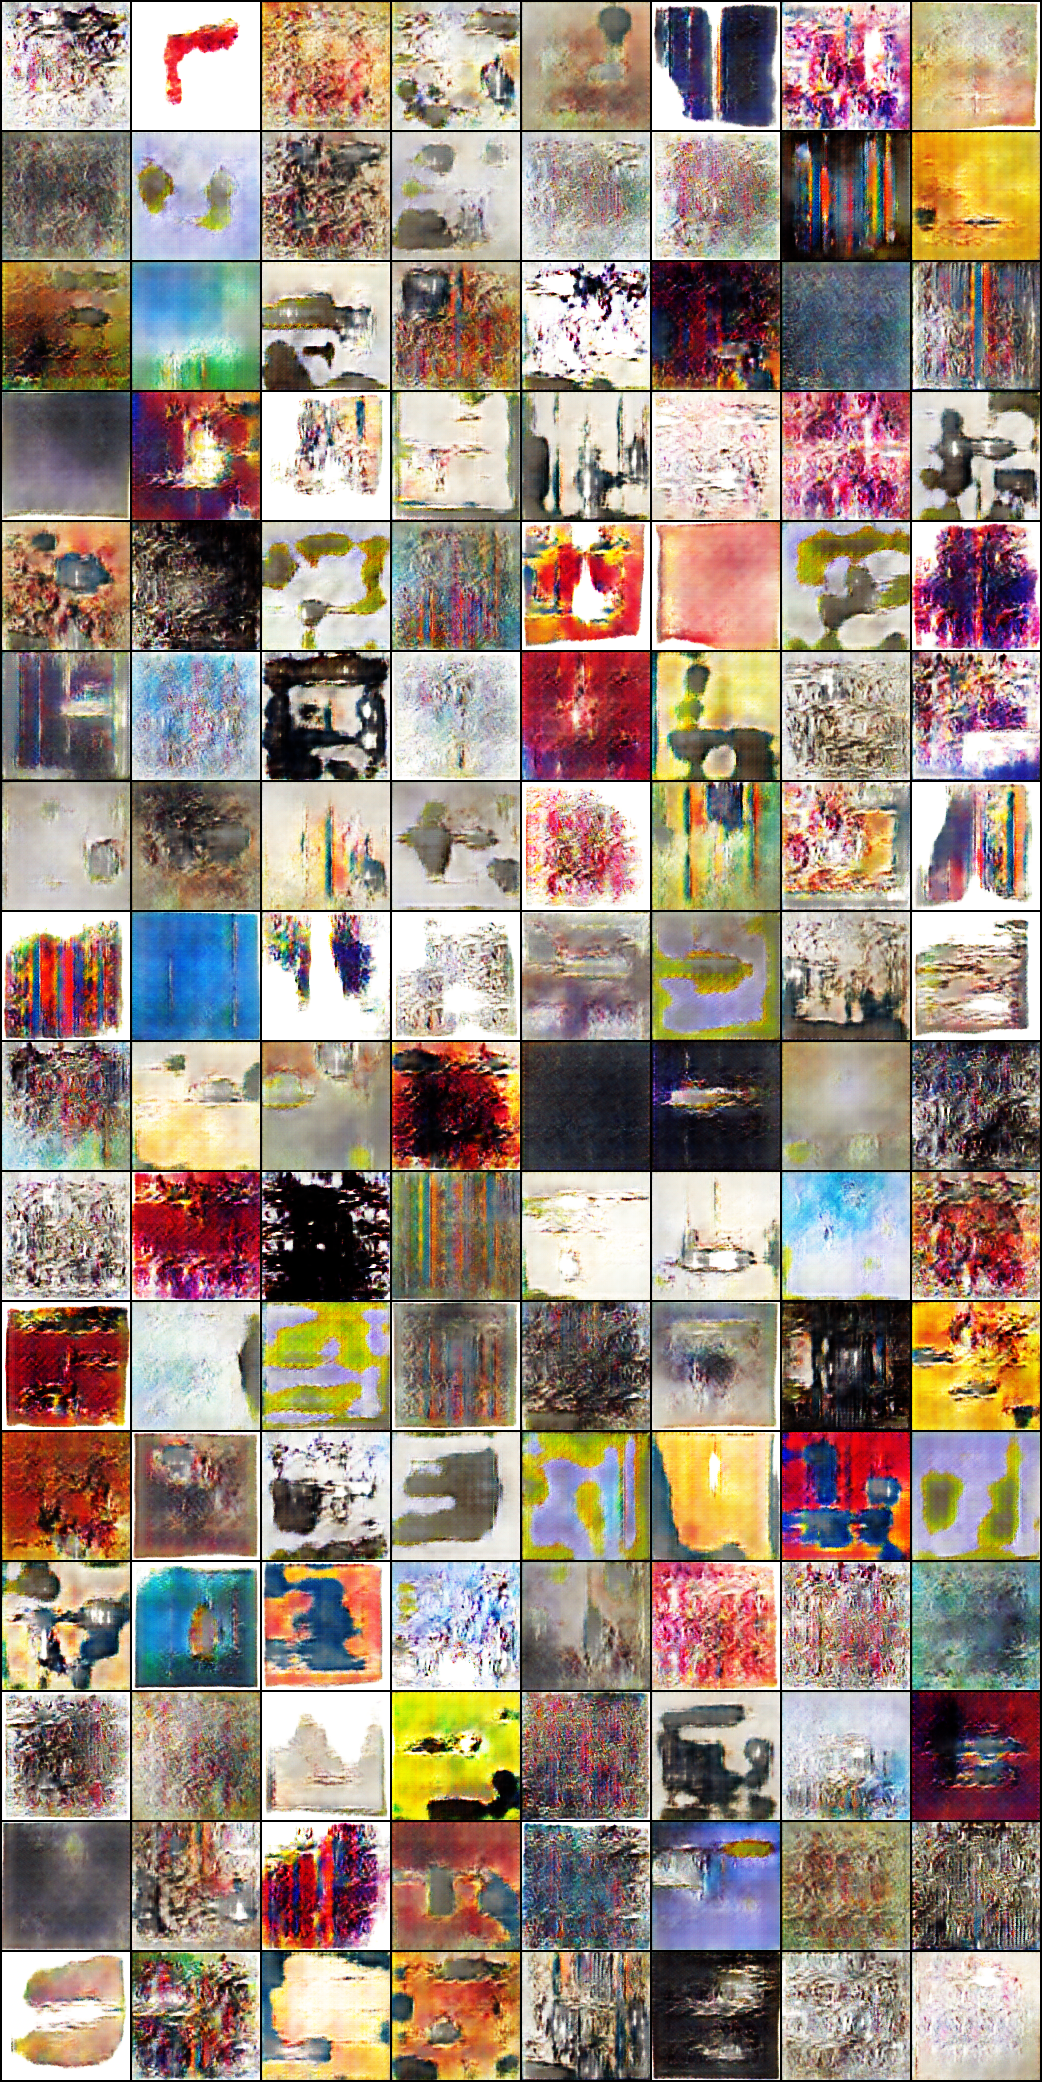

In [ ]:
Image("./generated/generated-images-0200.png")

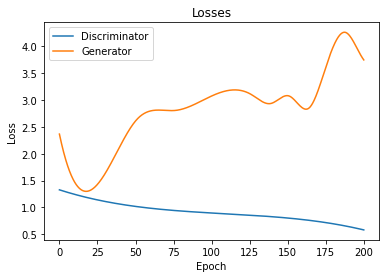

In [ ]:
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import numpy as np

losses_d = history[0][0]
losses_g = history[0][1]

x_d = range(1,201)
y_d = losses_d
s_d = UnivariateSpline(x_d, y_d, s=25)
x_d = np.linspace(0, 200, 1000)
y_d = s_d(x_d)

x_g = range(1,201)
y_g = losses_g
s_g = UnivariateSpline(x_g, y_g, s=200)
x_g = np.linspace(0, 200, 1000)
y_g = s_g(x_g)

plt.plot(x_d, y_d)
plt.plot(x_d, y_g)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')
plt.show()

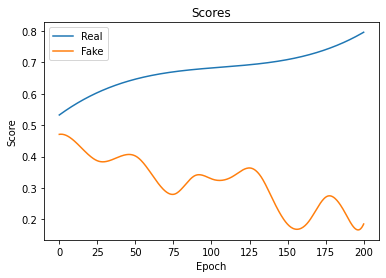

In [ ]:
scores_d = history[0][2]
scores_g = history[0][3]

x_d = range(1,201)
y_d = scores_d
s_d = UnivariateSpline(x_d, y_d, s=5)
x_d = np.linspace(0, 200, 500)
y_d = s_d(x_d)

x_g = range(1,201)
y_g = scores_g
s_g = UnivariateSpline(x_g, y_g, s=5)
x_g = np.linspace(0, 200, 500)
y_g = s_g(x_g)

plt.plot(x_d, y_d)
plt.plot(x_d, y_g)
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend(['Real', 'Fake'])
plt.title('Scores')
plt.show()

In [ ]:
from torchsummary import summary

summary(generator, (128, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 1024, 4, 4]       2,097,152
       BatchNorm2d-2           [-1, 1024, 4, 4]           2,048
              ReLU-3           [-1, 1024, 4, 4]               0
   ConvTranspose2d-4            [-1, 512, 8, 8]       8,388,608
       BatchNorm2d-5            [-1, 512, 8, 8]           1,024
              ReLU-6            [-1, 512, 8, 8]               0
   ConvTranspose2d-7          [-1, 256, 16, 16]       2,097,152
       BatchNorm2d-8          [-1, 256, 16, 16]             512
              ReLU-9          [-1, 256, 16, 16]               0
  ConvTranspose2d-10          [-1, 128, 32, 32]         524,288
      BatchNorm2d-11          [-1, 128, 32, 32]             256
             ReLU-12          [-1, 128, 32, 32]               0
  ConvTranspose2d-13           [-1, 64, 64, 64]         131,072
      BatchNorm2d-14           [-1, 64,

In [ ]:
summary(discriminator, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           3,072
       BatchNorm2d-2           [-1, 64, 64, 64]             128
         LeakyReLU-3           [-1, 64, 64, 64]               0
            Conv2d-4          [-1, 128, 32, 32]         131,072
       BatchNorm2d-5          [-1, 128, 32, 32]             256
         LeakyReLU-6          [-1, 128, 32, 32]               0
            Conv2d-7          [-1, 256, 16, 16]         524,288
       BatchNorm2d-8          [-1, 256, 16, 16]             512
         LeakyReLU-9          [-1, 256, 16, 16]               0
           Conv2d-10            [-1, 512, 8, 8]       2,097,152
      BatchNorm2d-11            [-1, 512, 8, 8]           1,024
        LeakyReLU-12            [-1, 512, 8, 8]               0
           Conv2d-13           [-1, 1024, 4, 4]       8,388,608
      BatchNorm2d-14           [-1, 102